# <span style="font-family: Arial, sans-serif; color:lightskyblue">Boosting Beyond Trees</span>

Gradient boosting is typically associated with decision trees as base learners, but what if we explored alternative models? In this notebook, we experiment with different base learners, such as linear models and neural networks, to assess their performance in gradient boosting for classification tasks.

We'll examine the efficacy of these models and see whether they can be effectively boosted in a similar way to decision trees.

Author: https://github.com/deburky

## Gradient Boosting Model

In [101]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.inspection import DecisionBoundaryDisplay
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# set font to 0xproto
# import font Nunito
plt.rcParams['font.family'] = 'Avenir'

np.random.seed(42)

# Define a loss for classification (binary cross-entropy)
class LogisticLoss:
    @staticmethod
    def compute_gradients(y_true, y_pred):
        p_pred = sigmoid(y_pred)
        return p_pred - y_true

    @staticmethod
    def compute_hessians(y_true, y_pred):
        p_pred = np.clip(sigmoid(y_pred), 1e-15, 1 - 1e-15)
        return p_pred * (1 - p_pred)  # Hessian of log loss

class SquaredLoss:
    @staticmethod
    def compute_gradients(y_true, y_pred):
        return y_pred - y_true

    @staticmethod
    def compute_hessians(y_true, y_pred):
        return np.ones_like(y_true)


class BaseGradientBoosting(BaseEstimator):
    def __init__(
        self,
        n_iter=100,
        learning_rate=0.1,
        loss=None,
        base_learner="tree",
        base_learner_params=None,
        subsample=1.0,
        bootstrap=True,
        task="regression"
    ):
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.subsample = subsample
        self.bootstrap = bootstrap
        self.base_learner_type = base_learner
        self.base_learner_params = base_learner_params if base_learner_params is not None else {}
        self.task = task
        self.classes_ = None
        self.predictors = []
        self.loss_history = []
        self.val_loss_history = []
        self.is_fitted_ = False

    def fit(self, X, y, X_val=None, y_val=None, plot_steps=False):
        if self.task == "classification":
            self.classes_ = np.unique(y)
            if len(self.classes_) != 2:
                raise ValueError("Only binary classification is supported.")
        n_samples = X.shape[0]
        y_pred_train = np.zeros(n_samples, dtype=np.float64)
        
        if isinstance(X, pd.DataFrame):
            X = X.values
        if X_val is not None and isinstance(X_val, pd.DataFrame):
            X_val = X_val.values

        # Reshape X and y if they are 1D
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            if X_val is not None:
                X_val = X_val.reshape(-1, 1)  # type: ignore

        for iteration in range(self.n_iter):
            # Compute the negative gradient (residuals)
            negative_gradient = -self.loss.compute_gradients(y, y_pred_train)

            # Subsampling the data
            if self.subsample < 1.0:
                sample_size = int(self.subsample * n_samples)
                if self.bootstrap:
                    indices = np.random.choice(n_samples, sample_size, replace=True)
                else:
                    indices = np.random.choice(n_samples, sample_size, replace=False)

                X_boot = X.iloc[indices] if isinstance(X, pd.DataFrame) else X[indices]
                negative_gradient_boot = negative_gradient[indices]
            else:
                X_boot = X
                negative_gradient_boot = negative_gradient

            # Train the base learner on the subsampled dataset
            if self.base_learner_type == "tree":
                new_predictor = DecisionTreeRegressor(**self.base_learner_params)
            elif self.base_learner_type == "linear":
                new_predictor = LinearRegression(**self.base_learner_params)
            elif self.base_learner_type == "mlp":
                new_predictor = MLPRegressor(**self.base_learner_params)

            new_predictor.fit(X_boot, self.learning_rate * negative_gradient_boot)
            y_pred_train += new_predictor.predict(X)

            # Store the trained base learner
            self.predictors.append(new_predictor)

            # Track the training loss
            if self.task == "regression":
                train_loss = mean_squared_error(y, y_pred_train)
            else:
                train_loss = log_loss(y, sigmoid(y_pred_train))
            self.loss_history.append(train_loss)

            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                if self.task == "regression":
                    val_loss = mean_squared_error(y_val, y_pred_val)
                else:
                    val_loss = log_loss(y_val, sigmoid(y_pred_val))
                self.val_loss_history.append(val_loss)

            if plot_steps and X.shape[1] == 2:
                self.plot_decision_boundary(X, y, iteration)
            else:
                raise ValueError("plot_steps is only available for 2D data.")

        self.is_fitted_ = True

    def plot_decision_boundary(self, X, y, iteration):
        if self.task == "classification":
            _, ax = plt.subplots(figsize=(4, 3), dpi=150)
            DecisionBoundaryDisplay.from_estimator(
                self,
                X,
                cmap='rainbow',
                grid_resolution=300,
                plot_method='contourf', # pcolormesh
                ax=ax
            )
            DecisionBoundaryDisplay.from_estimator(
                self,
                X,
                cmap='bone',
                plot_method="contour",
                alpha=0.8,
                levels=[0.5],
                linestyles="--",
                linewidths=2,
                ax=ax
            )
            # Add scatter plot of the data points
            plt.scatter(
                X[y == 0][:, 0], 
                X[y == 0][:, 1], 
                color="#008eff", 
                s=12, 
                label="Class 0", 
                edgecolors='k',
                linewidths=0.5
            )
            plt.scatter(
                X[y == 1][:, 0], 
                X[y == 1][:, 1], 
                color="#ff3f3f", 
                s=12, 
                label="Class 1",
                edgecolors='k',
                linewidths=0.5
            )
            name_for_plot = {'tree': 'Decision Tree', 'linear': 'Linear Regression', 'mlp': 'MLP'}
            base_learner = name_for_plot[self.base_learner_type]
            plt.title(f"Base Learner: {base_learner} (Iteration {iteration + 1})")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.legend(loc="upper right", fontsize=8)
            plt.xlim(X[:, 0].min(), X[:, 0].max())
            plt.ylim(X[:, 1].min(), X[:, 1].max())
            plt.tight_layout()
            plt.show()
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        return np.sum([predictor.predict(X) for predictor in self.predictors], axis=0)

    def predict_proba(self, X):
        if self.task == "classification":
            p = sigmoid(self.predict(X))
            return np.column_stack((1 - p, p))
        else:
            raise ValueError("predict_proba is only available for classification tasks.")


class GradientBooster(BaseGradientBoosting, ClassifierMixin, RegressorMixin):
    def __init__(
        self,
        n_iter=100,
        learning_rate=0.1,
        loss=None,
        base_learner="tree",
        base_learner_params=None,
        subsample=1.0,
        bootstrap=True,
        task="regression"
    ):
        if loss is None:
            loss = SquaredLoss() if task == "regression" else LogisticLoss()
        super().__init__(n_iter, learning_rate, loss, base_learner, base_learner_params, subsample, bootstrap, task)

## Dataset

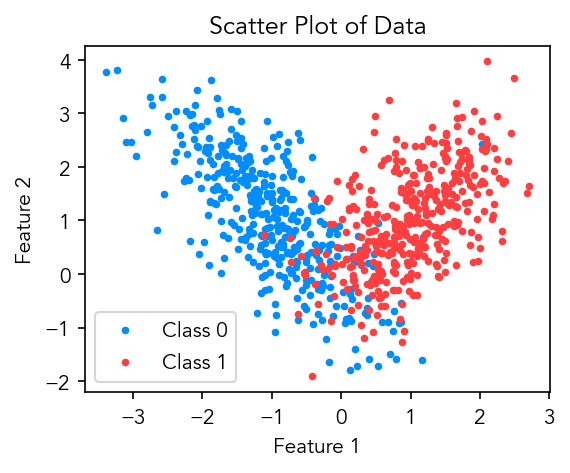

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def generate_dataset(dataset_type="classification", n_samples=1000):
    if dataset_type == "classification":
        # Generate a simple binary classification dataset
        X, y = make_classification(
            n_samples=n_samples,
            n_features=2,
            n_informative=2,
            n_redundant=0,
            n_clusters_per_class=1,
            random_state=0,
        )
    elif dataset_type == "P_shape":
        # Generate a "P" shaped dataset
        X = []
        y = []

        # Generate points along the vertical lines of "П"
        for _ in range(n_samples // 3):
            x = np.random.uniform(-2, -1)
            y_val = np.random.uniform(-2, 2)
            X.append([x, y_val])
            y.append(1)

            x = np.random.uniform(1, 2)
            y_val = np.random.uniform(-2, 2)
            X.append([x, y_val])
            y.append(1)

        # Generate points along the top horizontal line of "П"
        for _ in range(n_samples // 3):
            x = np.random.uniform(-2, 2)
            y_val = np.random.uniform(1.5, 2)
            X.append([x, y_val])
            y.append(1)

        # Generate random points outside the "П" shape for Class 0
        for _ in range(n_samples):
            x = np.random.uniform(-3, 3)
            y_val = np.random.uniform(-3, 3)
            if not (
                -2 <= x <= 2 and -2 <= y_val <= 2 and (x < -1 or x > 1 or y_val > 1.5)
            ):
                X.append([x, y_val])
                y.append(0)

        X, y = np.array(X), np.array(y)

    elif dataset_type == "X_shape":
        # Generate an "X" shaped dataset
        X = []
        y = []

        # First diagonal (top-left to bottom-right) - Class 0
        for _ in range(n_samples // 2):
            x = np.random.uniform(-2, 2)
            y_val = x + np.random.uniform(-0.5, 0.5)
            X.append([x, y_val])
            y.append(0)

        # Second diagonal (top-right to bottom-left) - Class 1
        for _ in range(n_samples // 2):
            x = np.random.uniform(-2, 2)
            y_val = -x + np.random.uniform(-0.5, 0.5)
            X.append([x, y_val])
            y.append(1)

        X, y = np.array(X), np.array(y)
    else:
        raise ValueError(
            f"Unknown dataset_type: {dataset_type}. Choose from 'classification', 'P_shape', or 'X_shape'."
        )

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=0
    )

    return X_train, X_val, y_train, y_val


def plot_dataset(X, y, title="Scatter Plot of Data"):
    fig = plt.figure(figsize=(4, 3), dpi=150)
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color="#008eff", s=7, label="Class 0")
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color="#ff3f3f", s=7, label="Class 1")
    plt.legend()
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


# Example usage
X_train, X_val, y_train, y_val = generate_dataset(
    dataset_type="classification", n_samples=1000
)
plot_dataset(X_train, y_train, title="Scatter Plot of Data")

## Experiments

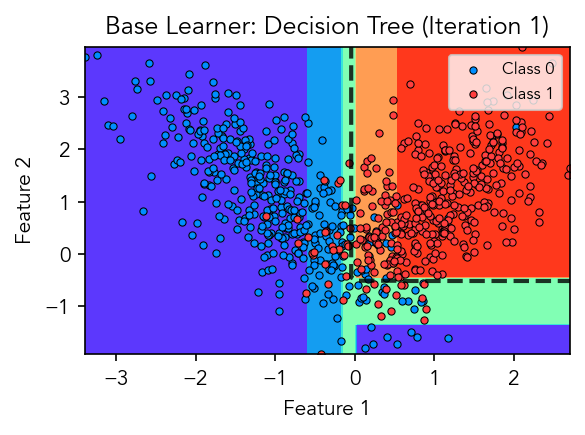

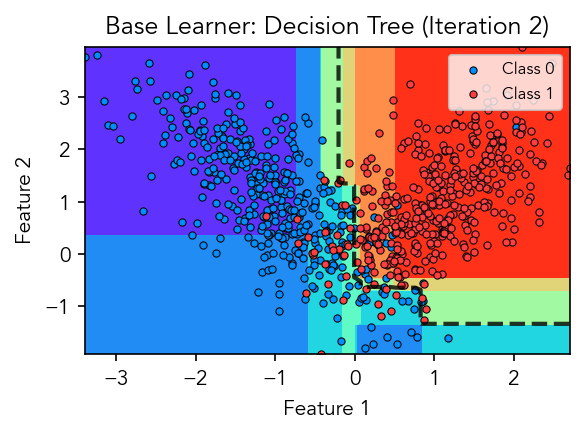

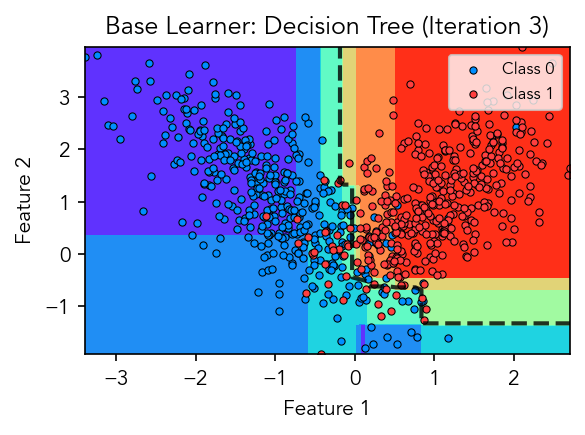

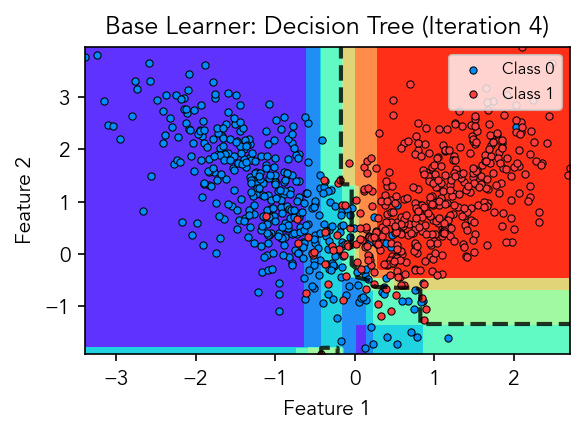

Train Gini: 0.96
Test Gini: 0.97


In [126]:
from sklearn.metrics import roc_auc_score

tree_params = {'max_depth': 3}
# Gradient Boosting Regressor model
gbr = GradientBooster(
    n_iter=4,
    learning_rate=1.0,
    subsample=1.0,
    base_learner="tree",
    base_learner_params=tree_params,
    task="classification"
)
gbr.fit(X_train, y_train, X_val, y_val, plot_steps=True)

preds_train = gbr.predict_proba(X_train)[:, 1]
preds_test = gbr.predict_proba(X_val)[:, 1]

gini_train = roc_auc_score(y_train, preds_train) * 2 - 1
gini_test = roc_auc_score(y_val, preds_test) * 2 - 1

print(f"Train Gini: {gini_train:.2f}")
print(f"Test Gini: {gini_test:.2f}")

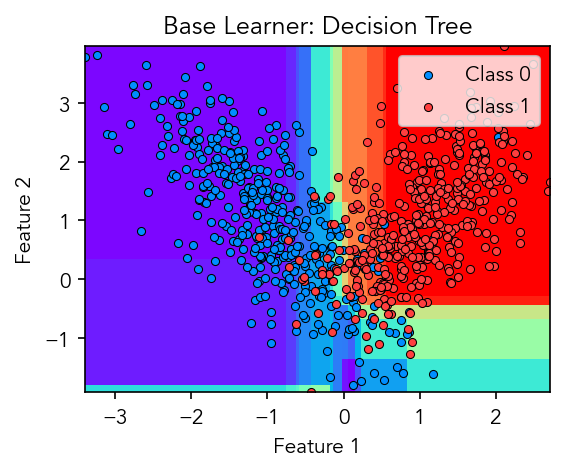

In [127]:
from sklearn.inspection import DecisionBoundaryDisplay

# Plot the decision boundary
_, ax = plt.subplots(figsize=(4, 3), dpi=150)
DecisionBoundaryDisplay.from_estimator(
    gbr, 
    X_train,
    cmap='rainbow',
    grid_resolution=200,
    plot_method='pcolormesh',
    ax=ax

)
# add scatter plot
ax.scatter(
    X_train[y_train == 0][:, 0],
    X_train[y_train == 0][:, 1],
    color="#008eff",
    s=15,
    label="Class 0",
    edgecolors='k',
    linewidths=0.5
)
ax.scatter(
    X_train[y_train == 1][:, 0],
    X_train[y_train == 1][:, 1],
    color="#ff3f3f", 
    s=15, 
    label="Class 1",
    edgecolors='k',
    linewidths=0.5
)
plt.xlim(X_train[:, 0].min(), X_train[:, 0].max())
plt.ylim(X_train[:, 1].min(), X_train[:, 1].max())
plt.title("Base Learner: Decision Tree")
plt.legend(loc="upper right")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

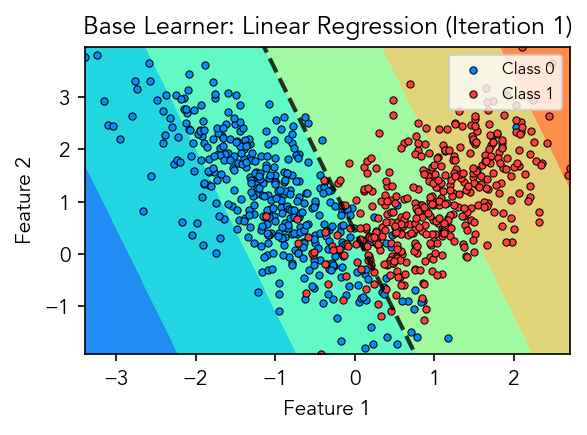

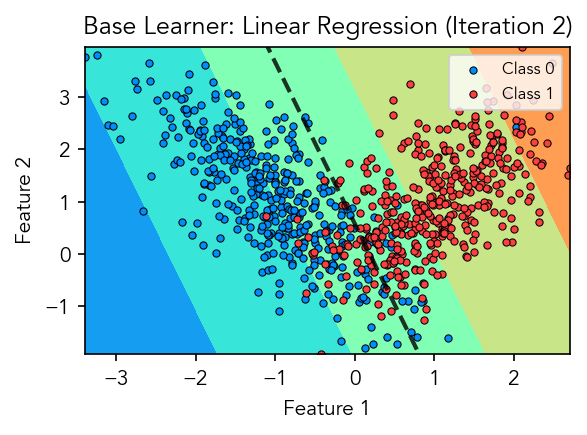

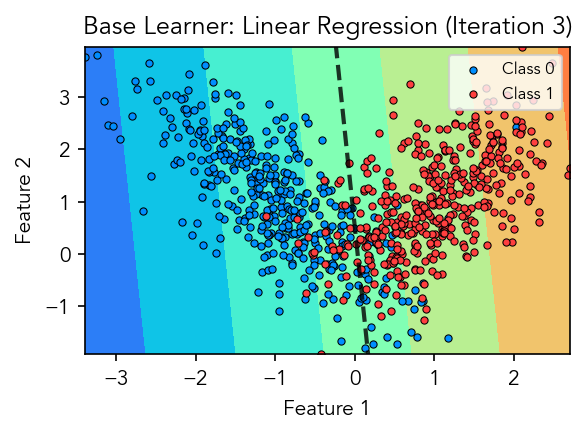

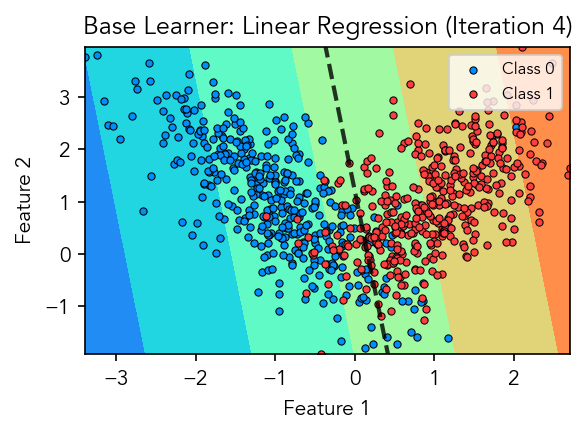

Train Gini: 0.94
Test Gini: 0.97


In [128]:
from sklearn.metrics import roc_auc_score

# Gradient Boosting Regressor model
gbr = GradientBooster(n_iter=4, subsample=0.01, bootstrap=False, base_learner="linear", task="classification")
gbr.fit(X_train, y_train, X_val, y_val, plot_steps=True)

preds_train = gbr.predict_proba(X_train)[:, 1]
preds_test = gbr.predict_proba(X_val)[:, 1]

gini_train = roc_auc_score(y_train, preds_train) * 2 - 1
gini_test = roc_auc_score(y_val, preds_test) * 2 - 1

print(f"Train Gini: {gini_train:.2f}")
print(f"Test Gini: {gini_test:.2f}")

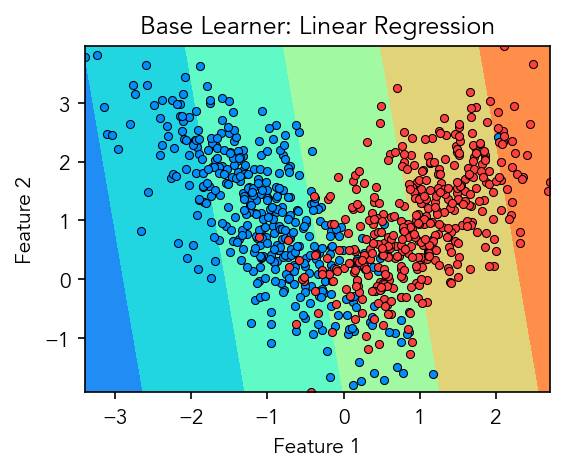

In [129]:
from sklearn.inspection import DecisionBoundaryDisplay

# Plot the decision boundary
_, ax = plt.subplots(figsize=(4, 3), dpi=150)
DecisionBoundaryDisplay.from_estimator(
    gbr,
    X_train,
    cmap='rainbow',
    grid_resolution=200,
    plot_method='contourf',
    ax=ax

)
# add scatter plot
ax.scatter(
    X_train[y_train == 0][:, 0],
    X_train[y_train == 0][:, 1],
    color="#008eff",
    s=15,
    label="Class 0",
    edgecolors='k',
    linewidths=0.5
)
ax.scatter(
    X_train[y_train == 1][:, 0],
    X_train[y_train == 1][:, 1],
    color="#ff3f3f", 
    s=15,
    label="Class 1",
    edgecolors='k',
    linewidths=0.5
)
plt.xlim(X_train[:, 0].min(), X_train[:, 0].max())
plt.ylim(X_train[:, 1].min(), X_train[:, 1].max())
plt.title("Base Learner: Linear Regression")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

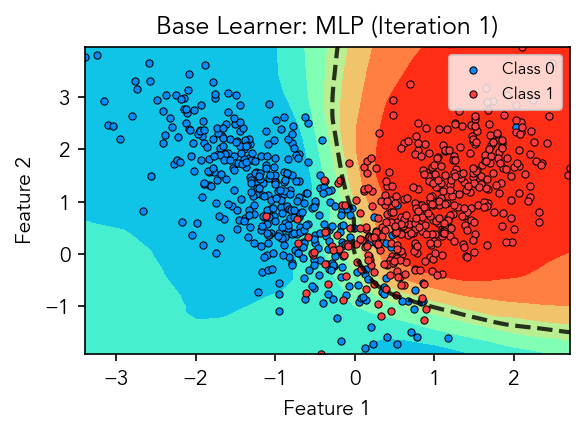

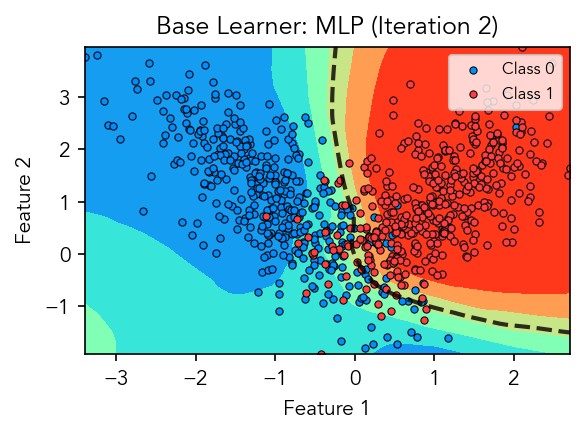

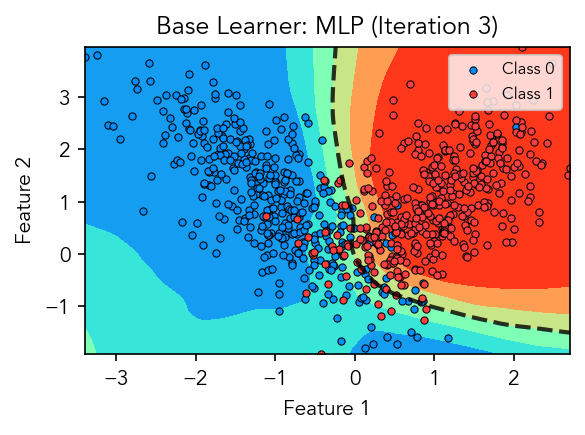

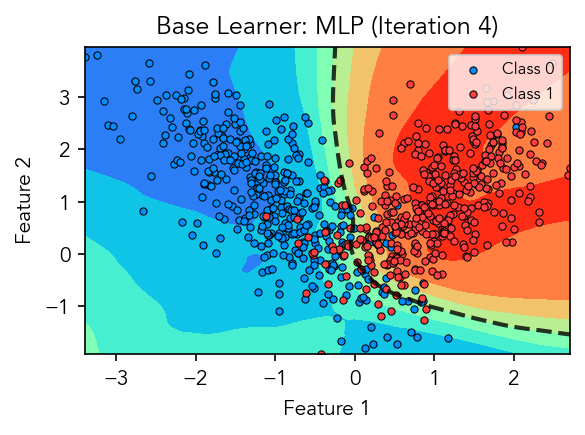

Train Gini: 0.96
Test Gini: 0.96


In [130]:
from sklearn.metrics import roc_auc_score

mlp_params = {'hidden_layer_sizes': (128, 32, ), 'max_iter': 100, 'random_state': 42, 'activation': 'relu'}

# MLP as base learner
gbr = GradientBooster(
    n_iter=4,
    learning_rate=1.0,
    subsample=1.0,
    base_learner="mlp",
    base_learner_params=mlp_params,
    task="classification"
)
gbr.fit(X_train, y_train, X_val, y_val, plot_steps=True)

preds_train = gbr.predict_proba(X_train)[:, 1]
preds_test = gbr.predict_proba(X_val)[:, 1]

gini_train = roc_auc_score(y_train, preds_train) * 2 - 1
gini_test = roc_auc_score(y_val, preds_test) * 2 - 1

print(f"Train Gini: {gini_train:.2f}")
print(f"Test Gini: {gini_test:.2f}")

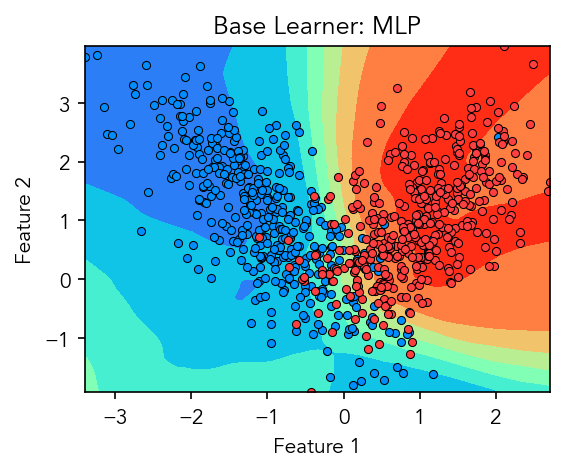

In [131]:
from sklearn.inspection import DecisionBoundaryDisplay

# Plot the decision boundary
_, ax = plt.subplots(figsize=(4, 3), dpi=150)
DecisionBoundaryDisplay.from_estimator(
    gbr, 
    X_train,
    cmap='rainbow',
    grid_resolution=300,
    plot_method='contourf',
    ax=ax

)
# add scatter plot
ax.scatter(
    X_train[y_train == 0][:, 0],
    X_train[y_train == 0][:, 1],
    color="#008eff",
    s=15,
    label="Class 0",
    edgecolors='k',
    linewidths=0.5
)
ax.scatter(
    X_train[y_train == 1][:, 0],
    X_train[y_train == 1][:, 1],
    color="#ff3f3f", 
    s=15, 
    label="Class 1",
    edgecolors='k',
    linewidths=0.5
)
plt.xlim(X_train[:, 0].min(), X_train[:, 0].max())
plt.ylim(X_train[:, 1].min(), X_train[:, 1].max())
plt.title("Base Learner: MLP")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()